# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [8]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))
data.shape

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


(45222, 14)

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [6]:
from collections import Counter
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000    
n_greater_50k = data[data.income == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / float(n_records) *100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

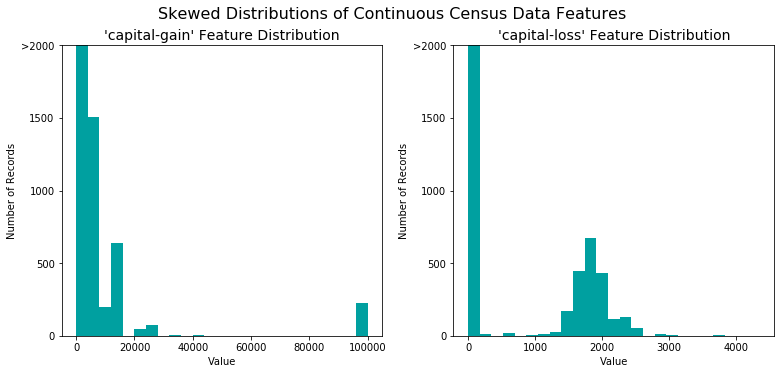

In [9]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

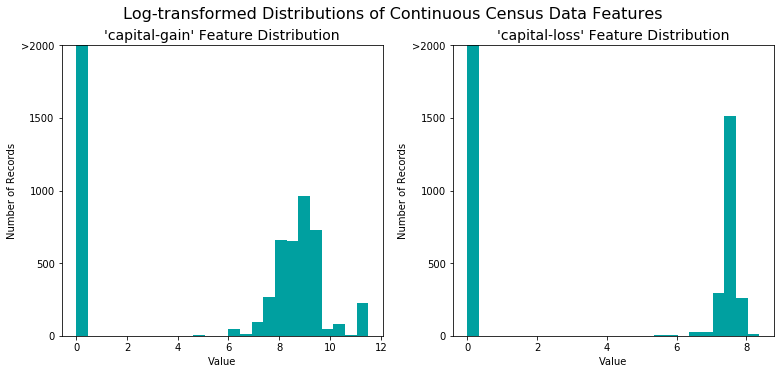

In [10]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [72]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw, columns=['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# TODO: Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw, drop_first=True)['>50K']

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [73]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [105]:
# TODO: Calculate accuracy

from sklearn.metrics import fbeta_score

y_pred=[]

total = income.shape[0]
TP = np.sum(income)

accuracy = float(TP) / float(total)


for i in range (0, len(income)):
    y_pred.append(1)

# TODO: Calculate F-score using the formula above for beta = 0.5
FP = income.value_counts()[0]
predicted_yes = TP + FP
precision = float(TP) / float(predicted_yes)

FN = 0
actually_yes = TP + FN
recall = float(TP) / float(actually_yes)

fscore = (1 + 0.5**2) * float(precision * recall) / float(0.5**2 * precision + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

Naive Bayes (NB, based on Bayes' Theorem, Thomas Bayes in 1763) can be used in a text classificaiton task - sentimental classification. For example, based on the words extracted from online social medias, predict if the this person is happy nor not happy (https://inclass.kaggle.com/c/si650winter11). Because it assumes features (words) are independent of each other, NB classifier can compute high dimential features (words) very quickly on training data. The weakness is also that it assumes feature independency. Because words are not related to each other (however it is dependent only to happyness or unhappyness) it can confuse NB when lots of happy words appear in the unhappy texts. On the other hand, it can also happen when both happy and unhappy texts have identical words. For example, cry can be unhappy or happy, depending on the context. This problem contains 33052 data points (sentences) and probably over 5000 discrete features (words) and only 2 classes - happy and unhappy feeling. All NB does is just keep muliplying discrete features, updating prior probability and make inferences on the classes the words belong. The flat simple muliplications makes the computational complexity very fast, for example, is only O(5000*2) = O(10000) ((https://brilliant.org/wiki/naive-bayes-classifier/?subtopic=machine-learning&chapter=classification) ). The probabilistic algorithm might not be perfect for finding donors, because features like occupation and capital-gain and marital-status are dependent and correlated to each other instead of independent, and this affects the prediction accuracy and fscore (https://www.youtube.com/watch?v=feBKiAdhYkc&list=PLBv09BD7ez_6CxkuiFTbL3jsn2Qd1IU7B&index=11).

On the other hand, Support Vector Machine (SVM by Vladimir Vapnik in 1963) is one the best and widely used supervised learning geometry method (https://brilliant.org/wiki/support-vector-machines/) today which is not based on probability (once it is trained, it gives 100% certainty of the data point class). The SVM works on seperating data points that are further apart. First, it lays the data points on a multi-demensional "space" and learns to seperate data points belonging to different classes in linear fashion and maximizes the gap betwen them, so that the split is not biased to neither side of class and has equal potential to expect incoming real world data set. Second, the SVM takes new data point into the "space" and predicts which class it belongs to, depending on where does it fall on the side of seperation. Not only the SVM works on linear classfication, it works on non-linear too: if the data points aren't linearly seperable: imagine data points are layed flat on a sheet of papar, and someone walks in and folds the papaer into a 'watermelon', so that the person can find a 'clear ninja cut' in between, therefore seperating the 'seeds' - data points. This is called kernel trick. The SVM performs extremly well when the data set is small, but it performs poorly when the data set is large because it takes too much time training each data point very carefully. The SVM outperforms other models in small image recognition such as recognizing handwritten digits (https://shankarmsy.github.io/posts/svm-sklearn.html). Because the image data feature (pixels) is continuous, the non-linear kernel (rbf) makes it possible a smoothier seperation boundary between different images in higher dimensional space (kernel trick) (https://www.quora.com/Why-does-linear-kernelized-SVM-perform-much-better-on-text-data-than-on-image-data). The SVM solves what probalistic algorithm falls: it does not care about data points that are very close to each other. The SVM seperates data points that are further apart and naturally thinks like my intuition close data points belong to same crowd. The distance algorithm works well with fidning donors, because it is not a textual analytical problem and it considers data points overall close to each other exhibits similarity in distribution (https://en.wikipedia.org/wiki/Support_vector_machine).

Decision Tree (ID3 Iterative Dichotomiser 3 by Ross Quinlan in 1986) is a geometry method that splits data points into a tree of leaves througth branches, by dicisions made on each level of branches. These tree leaves are learnt by asking simple questions, like a game of 20 questions (https://shapeofdata.wordpress.com/2013/07/02/decision-trees/). The answers are then turned into numerical representations and form thresholds on a multi-dimentional space. The tresholds are the decision bondaries that group similar data points into clusters of classes, based on entropy, a method of maximizing purity: grouping same class data points in the same region and kicking out the data points that are different classes. In theory, the Decision Tree iterates asking quesitons untill it reaches a state where it forms all possible regions that do not contain data points belonging to different classes (in practice however, the tree can stop growing at some point where regions have mostly one class of data points than the other class and it is called pruning). One application of Decision Tree is to predict for the bank if the loans are going to be paid on time (https://www.kaggle.com/kubo56/analysis-decision-tree-default-prediction). It is good because it takes larger data set and takes resonable time to train. Also its tree graph is easy to understand and interprete. The less useful features can be discarded and only more important features are remained for building model. The logic is easily explained by boolen logic. It works on both numerical and categorical data. However it can happend at the times when input training data changes a bit, resulting in big change in the tree structure and final predictions. It can also be a problem when Decision Tree overfits the training data and does not generalize well leading to high variance error and reducing accuracy (https://www.youtube.com/watch?v=BqOgaENTr08&index=13&list=PLBv09BD7ez_4_UoYeGrzvqveIR_USBEKD). Opimization can be reached by pruning: cutting unnecessary branches and maintain a good shape to train faster and less prediction errors due to overfitting. The Decision Tree works with finding donors very well because it works on both numerical and categorical data: the numerical data do not need to be normalized and categorical data do not need to converted to dummies. This gives the geometry algorithm convenience to handle different sorts of data points and overall compatibility of solving different problems (https://www.youtube.com/watch?v=N08cHUKxENE&list=PLBv09BD7ez_4_UoYeGrzvqveIR_USBEKD&t=14). Finally the time cost is considerably faster than SVM on larger data points.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [110]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    i = sample_size
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:i], y_train[:i])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


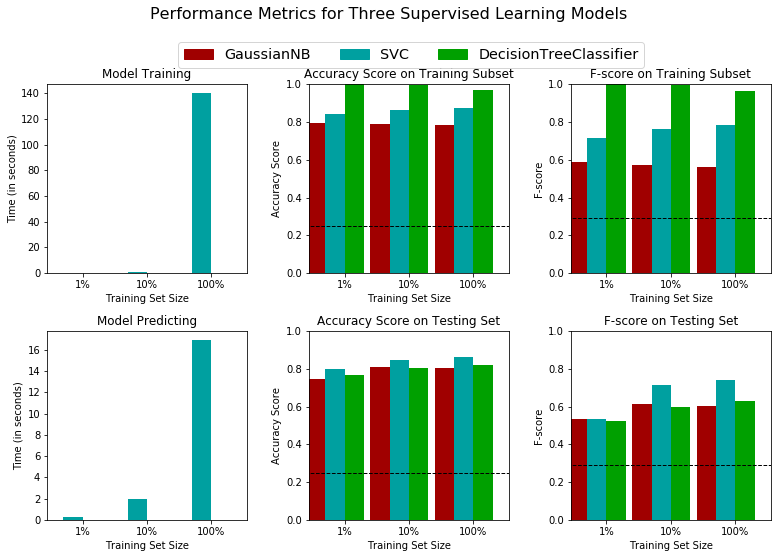

In [111]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score, accuracy_score

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=5)
clf_C = SVC(kernel='rbf', random_state=5)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(0.01 * X_train.shape[0])
samples_10 = int(0.1 * X_train.shape[0])
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** Based on the graph on Performance Metrics for Three Supervised Learning Models, I believe the SVM can be a fit to the problem, but not the best. The DecisionTree is your guy. As you can see, the accuracy score for SVM on testing set is the highest (about 84%) and DecisionTree has about 81%. The lower accuracy score on the training set indicates that the model learns the dataset well instead memorizing/overfitting the training set like DecisionTree. As you can see clearly in the graph, DecisionTree overfits the training data and both Accuracy adn F-score is perfectly 100% and SVM outperforms it in testing set. However, huge problem for SVM is the long training time, which is the longest among all three models, about 156 seconds. It does affect the performace on this particular problem because time is an import factor. Nobody wants to waste overnight for the result to come when it is too late. In fact, I will need to run overnight to compute the final results with C=1000 in k-folds validation. The F-score for DecisionTree on testing set is about 0.6 when trained on 100% on training set size and this indicates that 60% of the predictions on high income (>50K) are accurate and only 40% of the prediciton population are mistaken as high income. The SVM on F-score is better than DecisionTree, but if your client can not wait overnight then it is useless. Over all the SVM will not be a very good candidate considering such large data set with many features, without feature reduction.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Hello CharityML, I have just worked out for you one of the best models which is excellent for this particular job in predicting individuals' income based on the specific information provided such as age and working hours per week. The dataset you gave to me is split into two: train and test. The model SVM is trained on the train set and learns to identify high incomes (income >50K) and low incomes (income <=50K) and finds for itself the best boundary to seperate them, meaning that it passes through the middle of the data points from high income and low income. It maximizes the gap between data points on both sides. The model then tests on the test set and makes predicitons. Using this boundary, it thinks high income if a new person's information provided falls on the high income side, and thinks low income if it falls on the low income side. 

Let's say the data points just are ridiculous and won't let you cut straight between different labels, like in the problem of finding donors. What I did is a trick that folds the data points on a sheet of paper into a 'watermelon' so I can perform my specialized 'ninja cut' and folds it back into the paper, by which I can give you the labels that are nicely seperated. Now what you see on the paper is a sophiscated seperation representation that wanders around like a smart car without colliding with any label data points. One one side of the trace left by the smart car is high income, and on another is the low income.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [118]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


t0 = time()
# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=5)

# TODO: Create the parameters list you wish to tune
max_depth = range(1,20)
min_samples_split = range(2,40)
parameters = dict(max_depth=max_depth, min_samples_split=min_samples_split)

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=10, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print ("The training time is: {}".format(time() - t0))

t1 = time()

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print ("The testing time is: {}".format(time() - t1))

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

/Users/JiaHui/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The training time is: 1583.79681396
The testing time is: 0.365512132645
Unoptimized model
------
Accuracy score on testing data: 0.8182
F-score on testing data: 0.6272

Optimized Model
------
Final accuracy score on the testing data: 0.8543
Final F-score on the testing data: 0.7193


In [119]:
best_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            presort=False, random_state=5, splitter='best')

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478               |     0.8182              |     0.8543            |
    | F-score        |0.2917            |          0.6272         |    0.7193      |


**Answer: ** The Accuracy Score and F-score for a naive guess is the worst of all: this is because the naive guess is just a blind guess which does not consider any individuals information like age and capital-gain. However, the unoptimized model is much better (Accuracy=0.8182) and the optimized model (Accuracy=0.8543) is even better! This is because the Decision Tree takes into considerations of every possible information about an individual and come up with a well informed decision! The F(beta=0.5)-score steadly increases and reaches 0.72 meaning 72% of the prediction popuplation over high income are truly high income(>50K) and only 28% of the population are wrongly believed to be high income, which is the best of all three models!

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** occupation > education_level > education_num > hours-per-week > capital-gain. I think the occupation is the number one reason for high income. Because good job pays good. Education_level and education_num have great potential to make higher income. Then it comes hours-per-week, because the more hours one works, the more income. Capital-gain also directly takes part in high income, the more one gains in stock and real estate, the more income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

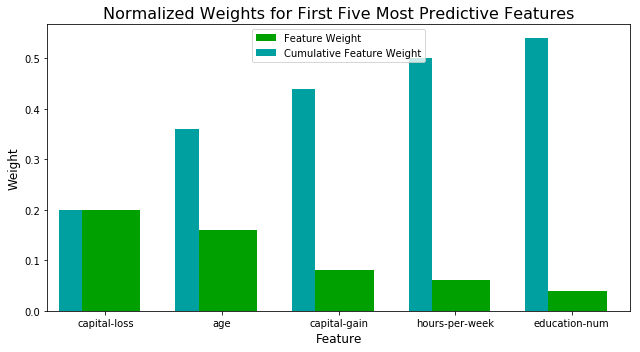

In [120]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(random_state=5)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** I got 3 features right: capital-gain, hours-per-week and education-num. As I can tell from the graph on the feature in green and cumulative feature weight in blue. The ones I missed are capital-loss and age. I think capital-loss is more relevant than my guess on occupation and education-level because it directly causes one to lose huge amount of income when in bad luck or short of insight of the way business going to grow in future. Age is also more relevant because I suppose the older one becomes the more income it scales upon (at least it is true in US and Canada)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [123]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)


# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8543
F-score on testing data: 0.7193

Final Model trained on reduced data
------
Accuracy on testing data: 0.8299
F-score on testing data: 0.6649


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The reduced data using only five features drops some Accuracy and F-score but improves greatly on the time it spends to train. It might not be obvious in the case of DecisionTreeClassifier but it certainly is in SVM. Although the training time is not a great factor in this problem, it will defintely make it much faster when it becomes a problem like in human face recognition and handwritten notes on cheques. In sum, if it is SVM that takes long to train, I will definitely use the reduced data for predicitons!

In [131]:
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=5).fit(X_train, y_train)

scores, pvalues = chi2(X_train, y_train)

coef = pd.DataFrame(zip(clf.coef_.T, np.exp(clf.coef_).T))
coef.columns = ['Coef_','Odds_Ratio_']
coef['P_values'] = pvalues
coef.index = X_train.columns

coef.Coef_ = coef.Coef_.astype(np.float64)
coef.Odds_Ratio_ = coef.Odds_Ratio_.astype(np.float64)

coef

,Coef_,Odds_Ratio_,P_values
age,0.022645,1.022903,0.000000e+00
education-num,0.163576,1.177715,0.000000e+00
capital-gain,0.000314,1.000314,0.000000e+00
capital-loss,0.000664,1.000664,0.000000e+00
hours-per-week,0.027673,1.028059,0.000000e+00
workclass_ Federal-gov,0.049573,1.050822,8.218949e-28
workclass_ Local-gov,-0.518771,0.595251,2.459998e-07
workclass_ Private,-0.415357,0.660104,8.411030e-32
workclass_ Self-emp-inc,-0.243064,0.784221,8.072705e-151
workclass_ Self-emp-not-inc,-0.868231,0.419693,1.389248e-06


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.